# Evaluation du modèle

### Importation

In [1]:
import os
import sys
import math

sys.path.append(os.path.abspath("../helper"))

In [2]:
import torch
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import seaborn as sns
import networkx as nx
import PIL.Image as Image
from captum.attr import Occlusion
from captum.attr import visualization as viz

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import GradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

from torchvision.transforms import autoaugment
import torch.nn.functional as F


In [16]:
from model import MyModel
from chargement_donnee import get_dataset_transformation, get_dataset_loader, ORIGINAL_PATH_DATASET_IMAGES, PATH_DATASET

### Choisir le 'device' pour entraînement sur gpu ou cpu

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Charger les données de tests

In [12]:
_, test_trmf = get_dataset_transformation()
nb_classes, _, test_loader = get_dataset_loader(ORIGINAL_PATH_DATASET_IMAGES, test_trmf, test_trmf)

Number of classes 196
Train dataset size is 8144
Test dataset size is 8041


### Chargement du modèle

Les détails du code sont dans le fichier 'helper/model.py' 

In [14]:
my_model = MyModel(nb_classes, device)

model_path = "../model/model-size512_512-split80_20-acc92.pth"
my_model.model.load_state_dict(torch.load(model_path))
my_model.model.eval() # Mode evaluation
()

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


()

#### Récupérer les vraies labels et calculer les labels (catégorie de voiture) prédits

In [15]:
true_labels, predicted_labels = my_model.compute_true_predicted_labels(test_loader)
cm = confusion_matrix(true_labels, predicted_labels)

Compute true labels and predicted labels: 100%|██████████| 252/252 [00:53<00:00,  4.69it/s]


<Figure size 1500x1000 with 0 Axes>

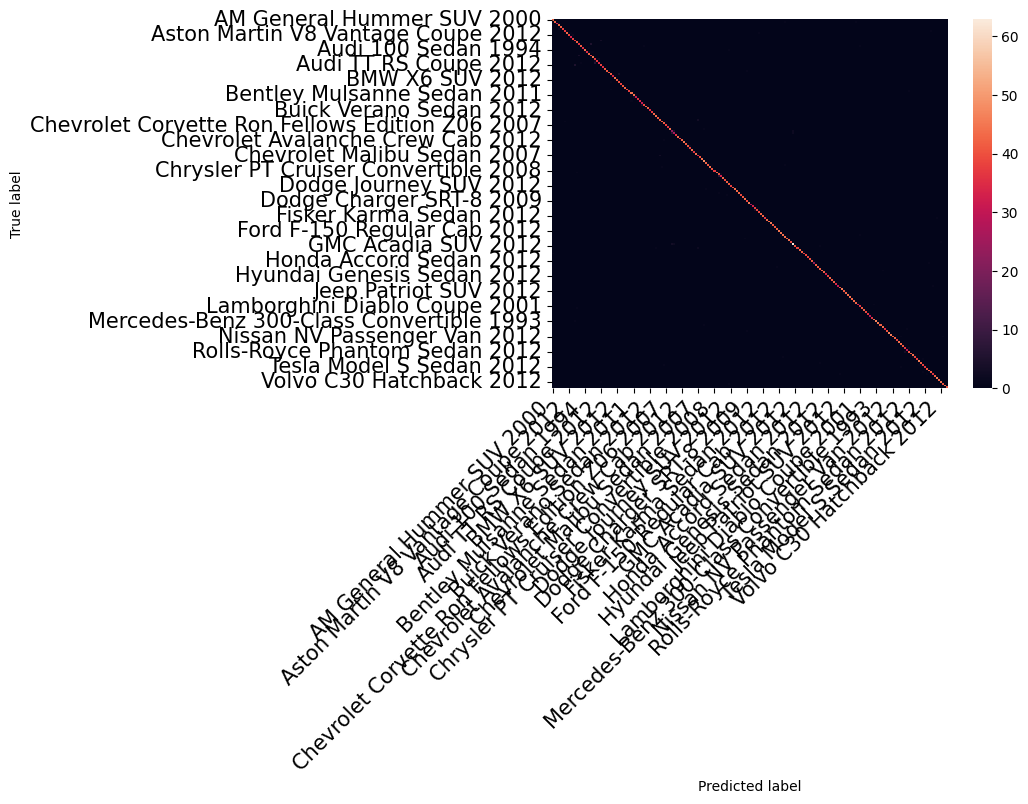

<Figure size 1500x1000 with 0 Axes>

In [17]:
df_names_generic = pd.read_csv(os.path.join(PATH_DATASET, "names.csv"), names=["name"])

class_names = list(df_names_generic['name'])

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
# Set the diagonal to zero, so we can see the other values better
# np.fill_diagonal(df_cm, 0)
heatmap = sns.heatmap(df_cm)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure(figsize=(15,10))

## Explicabilité du modèle via l'occlusion et CAM

In [20]:
random_image_path = os.path.join(ORIGINAL_PATH_DATASET_IMAGES, "test/Audi S4 Sedan 2012/05249.jpg")
print("random_image_path :", random_image_path)

image = Image.open(random_image_path)

img = test_trmf(image).float()
img = torch.autograd.Variable(img, requires_grad=True)
img = img.unsqueeze(0)
img = img.cuda()

random_image_path : /home/onyxia/work/army/dataset/car_data/car_data/test/Audi S4 Sedan 2012/05249.jpg


#### Occlusion

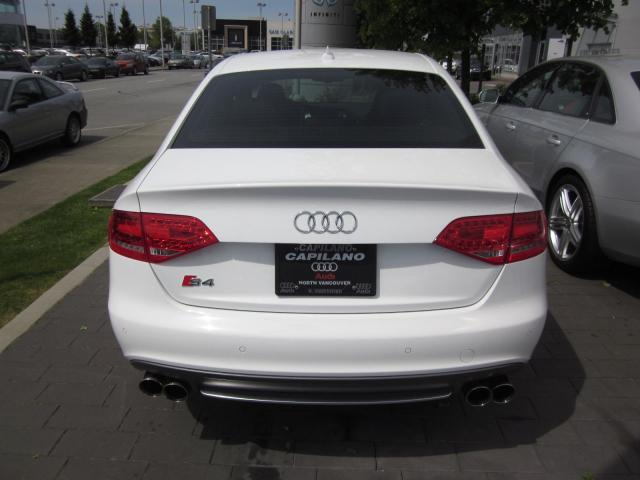

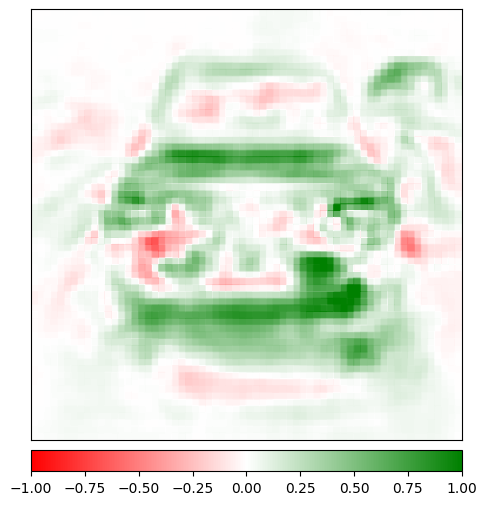

In [22]:
display(image)

output = my_model.model(img)
output = F.softmax(output, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
occlusion = Occlusion(my_model.model)

attributions_occ = occlusion.attribute(img,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

_ = viz.visualize_image_attr(np.transpose(attributions_occ, (1,2,0)),
                                      method="heat_map",
                                      sign="all",
                                      show_colorbar=True
                                     )

#### Analyse par GradCAMpp

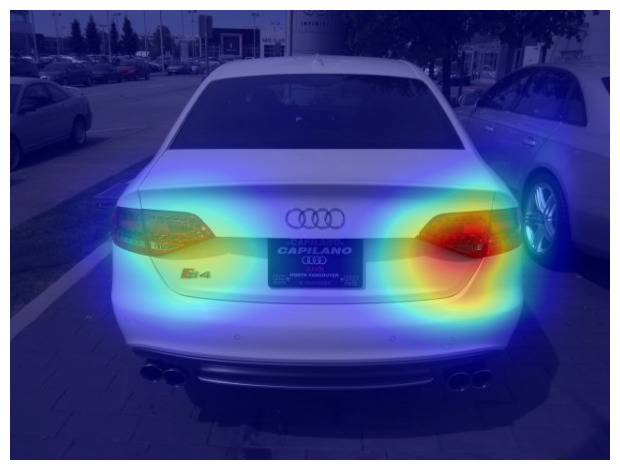

In [23]:
with GradCAMpp(my_model.model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = my_model.model(img)
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(image, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

#### Tout d'un coup

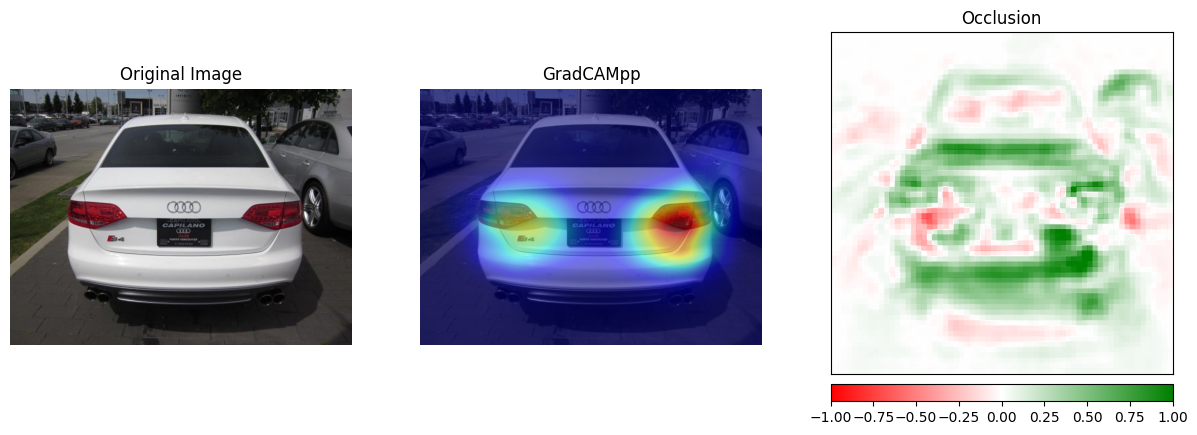

<Figure size 640x480 with 0 Axes>

In [25]:
original_image = np.asarray(image)
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Overlay mask on the original image
overlay_result = overlay_mask(image, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Plot overlay mask
axes[1].imshow(overlay_result)
axes[1].set_title('GradCAMpp')
axes[1].axis('off')

# Use the axis object from the visualization for the attributions
_ = viz.visualize_image_attr(np.transpose(attributions_occ, (1,2,0)),
                                      method="heat_map",
                                      sign="all",
                                      show_colorbar=True, plt_fig_axis=(fig, axes[2]),
                                      title="Occlusion"
                                     )

plt.tight_layout()
plt.show()

## Visualisation des résultats du modèle via les matrices de confusion

Pour évaluer les performances de notre modèle, la matrice de confusion peut être un très bon outil. En revanche, le dataset étant composé de 196 classes, il est très difficile de l'exploiter.
Pour remédier à ce problème, nous l'avons séparé en multiple sous-groupes en groupant les catégories qui étaient les plus confuses entre elles. Cela permet d'obtenir des sous-matrices de taille 5*5 par exemple et de pouvoir se concentrer sur ces 5 classes qui posent problèmes.

#### Chargement des classes

In [27]:
classes = np.genfromtxt(os.path.join(PATH_DATASET, "names.csv"), delimiter=',', dtype=str)

#### Séparer la matrice en sous-matrices

Méthode :

Une matrice de confusion peut être considérée comme une matrice d'adjacence représentant un graphe. Chaque liaison étant considérée comme une confusion, c'est à dire une image d'une voiture A considérée comment une voiture B ou vice-versa est considéré comme une liaison.
Donc deux noeuds liées, sont deux catégories de voiture confuses entre elles.
En calculant les composantes connexes, nous obtenons des sous-groupes de catégories qui sont confuses entre elles, rassemblant ainsi les catégorie que notre modèle ne parvient pas à classifier.

De plus, nous pouvons ne pas prendre en compte les erreurs minimes quand celle-ci ne dépasse pas le nombre de 1 entre deux classes (par exemple).

In [46]:
# calculer les composantes connexes
cm_copy = cm.copy()
cm_copy[cm_copy <= 1] = 0
G = nx.from_numpy_array(cm_copy)
composantes_connexes = list(nx.connected_components(G))
composantes_connexes = [[e for e in s] for s in composantes_connexes]
composantes_connexes

[[0],
 [1],
 [2],
 [3, 5],
 [4],
 [6],
 [7],
 [8, 10],
 [9],
 [24, 11],
 [12],
 [19, 13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [20],
 [21, 22, 23],
 [25],
 [26],
 [27],
 [28],
 [33, 29],
 [30],
 [31],
 [32],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40, 41],
 [42],
 [43],
 [44, 45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [72, 121, 53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59, 60, 119],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67, 68],
 [69, 70],
 [71],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82, 83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100, 101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [120],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138],
 [139],
 [140],
 [141],
 [142],
 [143],
 [144, 14

In [47]:
# séparer la matrice en sous-matrice avec les composantes connexes
sub_cms = [
    cm[sub,:][:,sub]
    for sub in composantes_connexes
]
sub_classes = [
    classes[sub]
    for sub in composantes_connexes
]

In [48]:
# Fonctions pour afficher les matrices
def show_cm(cm, classes, diag_zero = False, ax=None, show=True, rotation=None):
    cm_copy = cm.copy()
    if diag_zero:
        np.fill_diagonal(cm_copy, 0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_copy, display_labels=classes)

    disp.plot(ax=ax)
    
    if rotation:
        plt.xticks(rotation=rotation)
    if show:
        plt.show()

def show_cm_with_without_diag(cm, clases):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    show_cm(cm, classes, ax=axes[0], show=False)
    show_cm(cm, classes, diag_zero=True, ax=axes[1])

Nombre de sous-matrice : 8


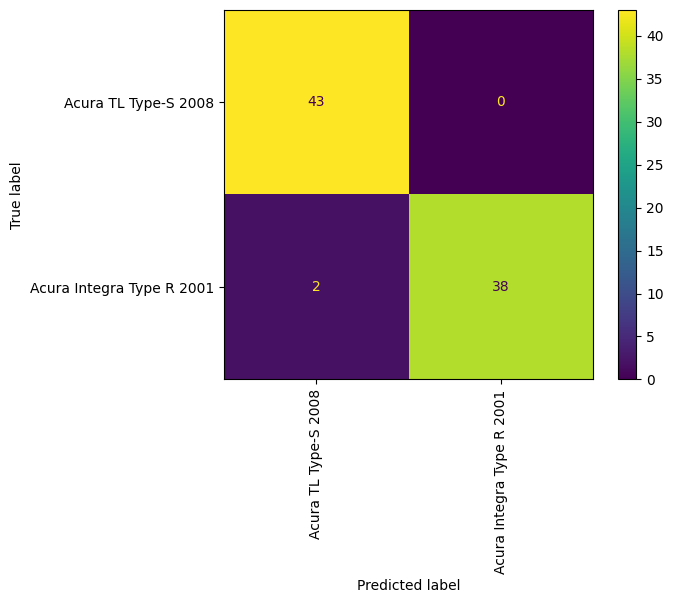

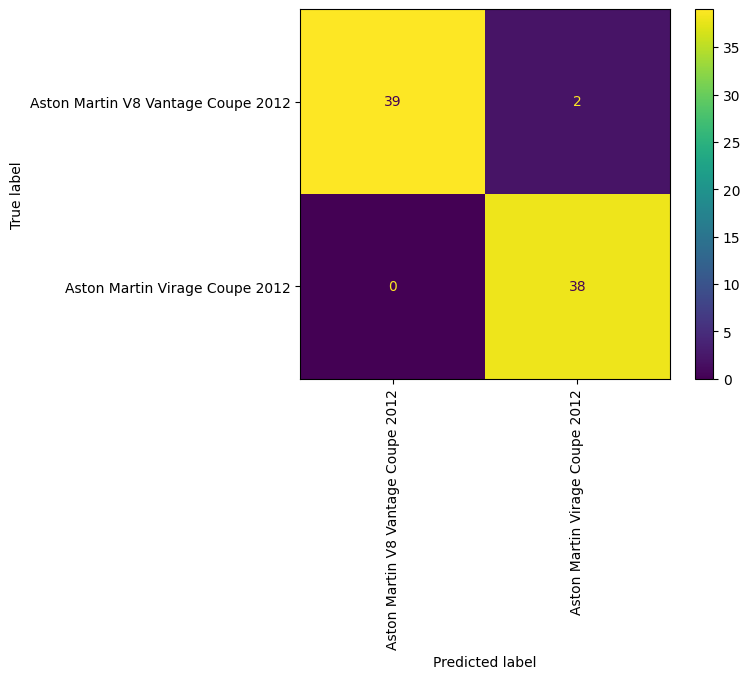

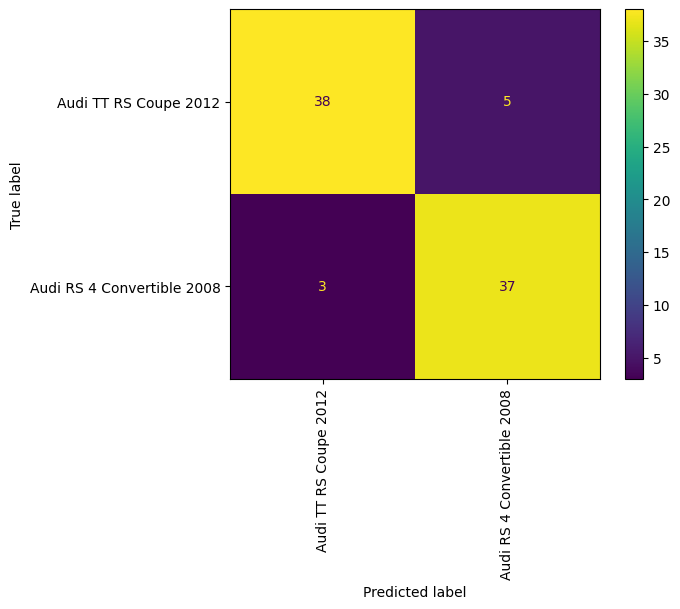

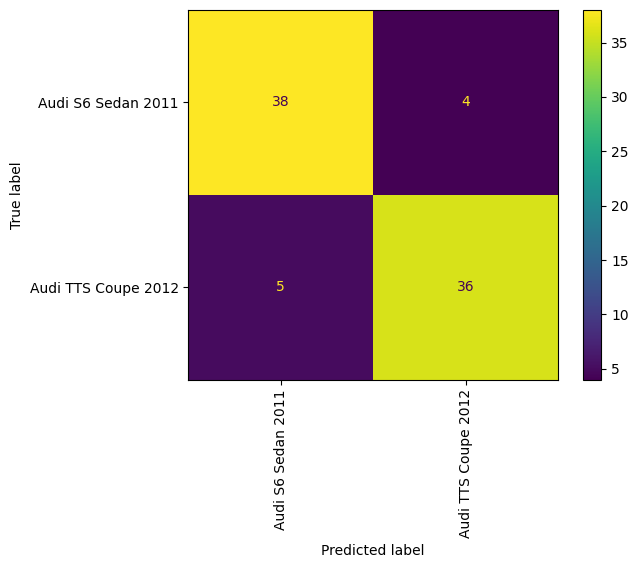

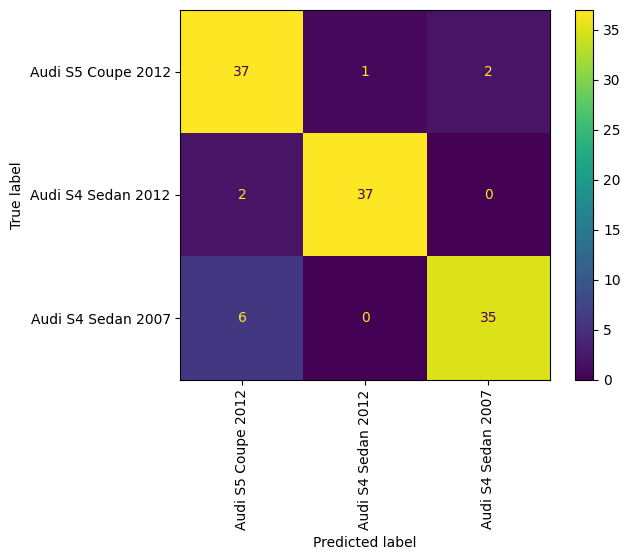

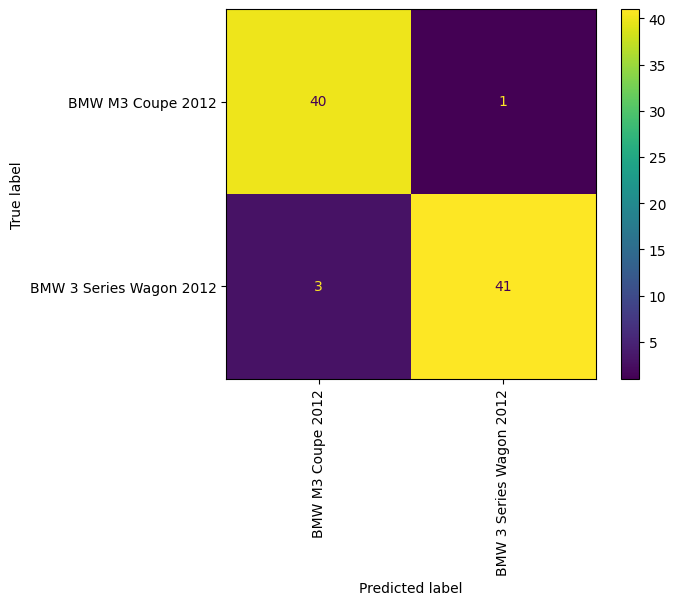

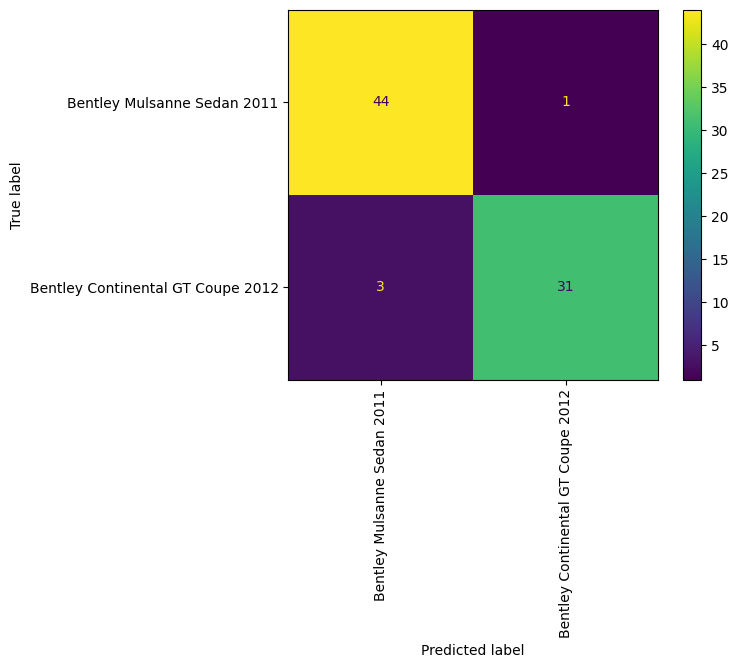

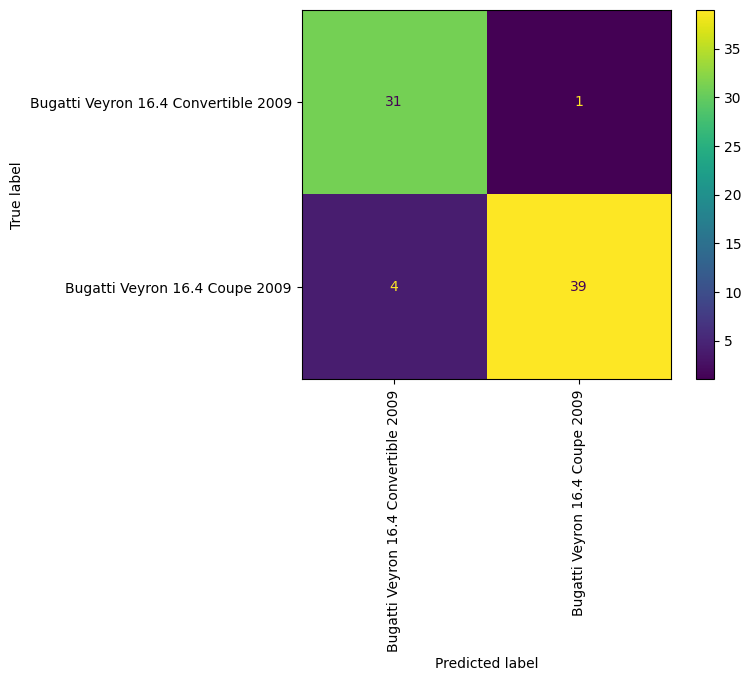

In [49]:
# supprimer les sous-matrices trop petites ou trop grandes
sub_cms, sub_classes = list(zip(*[
    (sub_cm, sub_classes)
    for sub_cm, sub_classes in zip(sub_cms, sub_classes)
    if 1 < sub_cm.shape[0] < 70
]))

# en garder mamximum 8
sub_cms = sub_cms[:8]
sub_classes = sub_classes[:8]

print("Nombre de sous-matrice :", len(sub_classes))

n_per_line = 1
nrows = math.ceil(len(sub_classes) / n_per_line)

for sub_cm, sub_class, i in zip(sub_cms, sub_classes, range(len(sub_cms))):
    show_cm(sub_cm, sub_class, diag_zero=False, rotation=90)